<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col="datetime", parse_dates=[0])
df.info()
print(df.index.is_monotonic)
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
df = df.resample('1H').sum()
df_day = df.resample('1D').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Данные упорядочены и в норме. 

## Анализ

Проведем анализ заказов по дням и часам на разных временных отрезках.

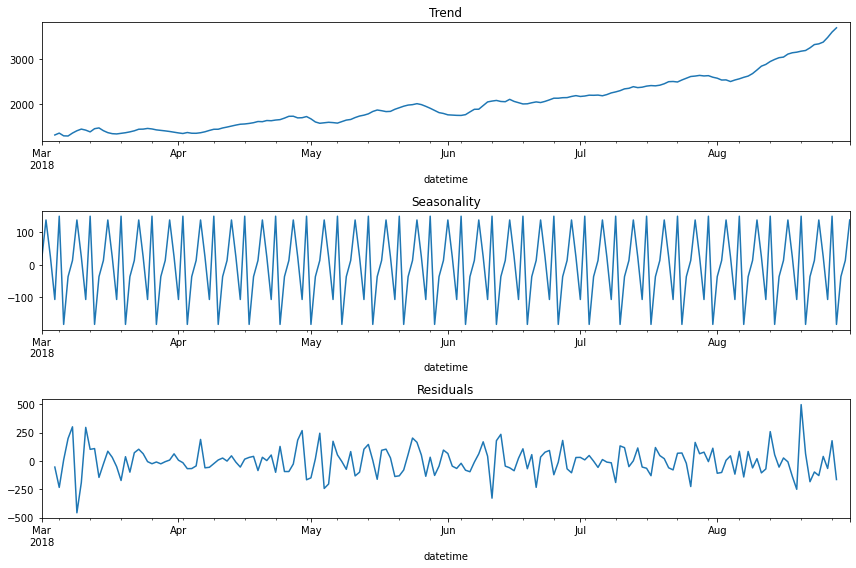

In [4]:
decomposed = seasonal_decompose(df_day)


plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

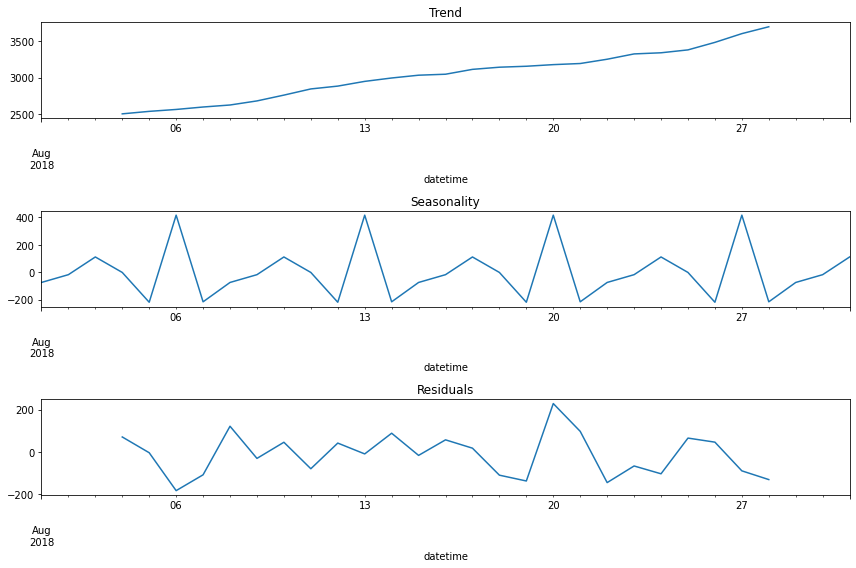

In [5]:
decomposed = seasonal_decompose(df_day['2018-08':'2018-08'])

plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Декомпозировав данные по дням, можно увидеть тренд на увеличение заказов такси, а также их сезонные пики в выходные дни. 

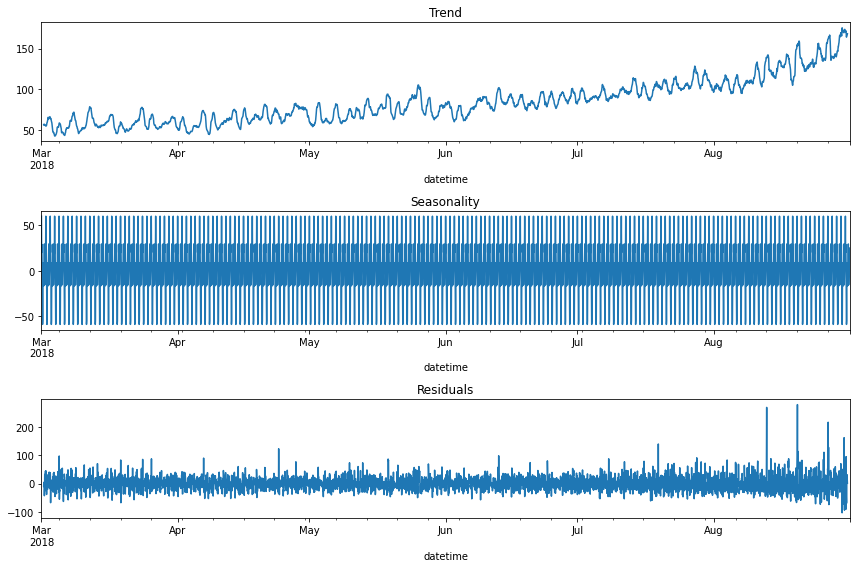

In [6]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

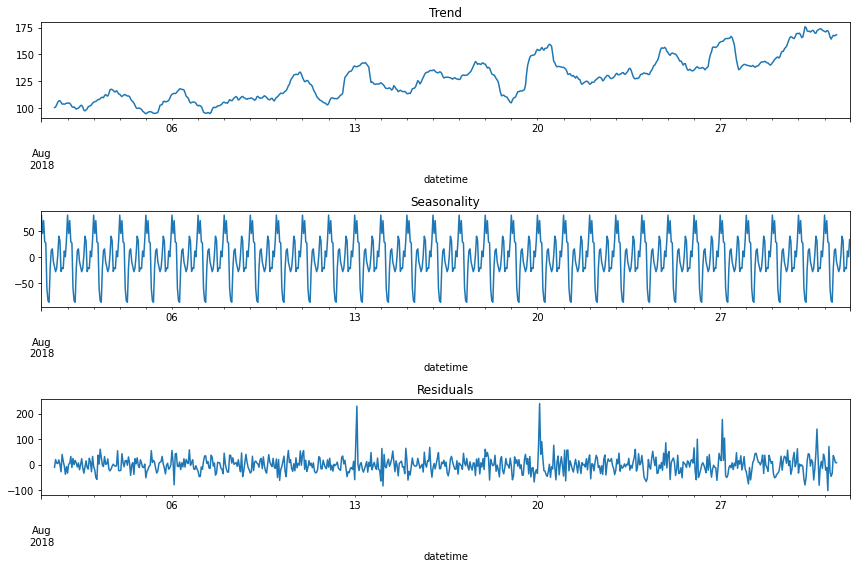

In [7]:
decomposed = seasonal_decompose(df['2018-08':'2018-08'])

plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

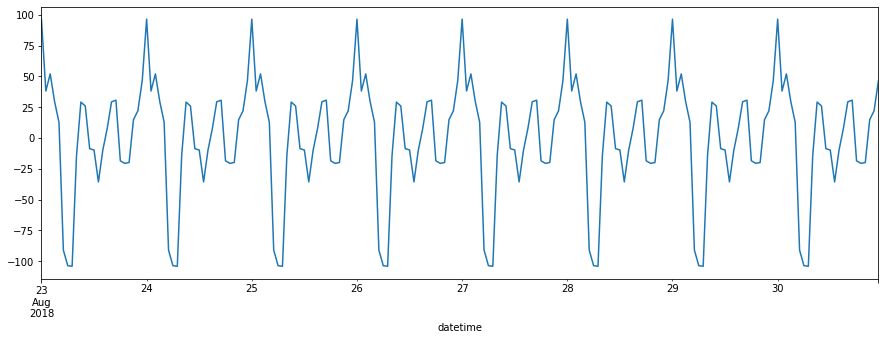

In [8]:
seasonal_decompose(df['2018-08-23':'2018-08-30']).seasonal.plot(ax=plt.gca())

Декомпозировав данные по часам, можно увидеть сезонность увличения заказов к вечеру, и их резкое снижение ночью. 

## Обучение

Для проверки модели на адекватность, новое значение x(t) будем прогнозировать предыдущим значением ряда, то есть x(t-1).

In [9]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse =  mean_squared_error(test['num_orders'], pred_previous['num_orders'], squared=False)
print("RMSE pred_previous модели:", rmse)

RMSE pred_previous модели: 58.856486242815066


In [10]:
def make_features(data, max_lag, rolling_mean_size):
    new = data.copy()
    new['dayofweek'] = new.index.dayofweek
    new['hour'] = new.index.hour
    for lag in range(1, max_lag + 1):
        new['lag_{}'.format(lag)] = new['num_orders'].shift(lag)

    new['rolling_mean'] = new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new

In [11]:
data = make_features(df, 24, 72)

In [12]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [13]:
data

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,162.861111
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.208333
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,164.041667


In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
data

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,162.861111
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.208333
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,164.041667


In [15]:
train

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-04 00:00:00,75,6,0,43.0,63.0,48.0,83.0,30.0,68.0,49.0,...,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,163.0,57.777778
2018-03-04 01:00:00,60,6,1,75.0,43.0,63.0,48.0,83.0,30.0,68.0,...,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,57.097222
2018-03-04 02:00:00,26,6,2,60.0,75.0,43.0,63.0,48.0,83.0,30.0,...,52.0,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,56.750000
2018-03-04 03:00:00,42,6,3,26.0,60.0,75.0,43.0,63.0,48.0,83.0,...,57.0,52.0,73.0,56.0,17.0,9.0,15.0,44.0,64.0,56.125000
2018-03-04 04:00:00,27,6,4,42.0,26.0,60.0,75.0,43.0,63.0,48.0,...,32.0,57.0,52.0,73.0,56.0,17.0,9.0,15.0,44.0,55.791667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,0,9,91.0,39.0,66.0,83.0,143.0,168.0,437.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,123.680556
2018-08-13 10:00:00,156,0,10,137.0,91.0,39.0,66.0,83.0,143.0,168.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,124.458333
2018-08-13 11:00:00,144,0,11,156.0,137.0,91.0,39.0,66.0,83.0,143.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,124.500000


In [16]:
X_train = train.drop(columns=['num_orders'])
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'])
y_test = test['num_orders']

In [17]:
tscv = TimeSeriesSplit(n_splits=3)

In [18]:
LR = LinearRegression()
LR.fit(X_train, y_train)
predicts_train = LR.predict(X_train)
print("RMSE обучающей выборки:", mean_squared_error(y_train, predicts_train, squared=False))

predicts_test = LR.predict(X_test)
print("RMSE тестовой выборки: ", mean_squared_error(y_test, predicts_test, squared=False))

RMSE обучающей выборки: 25.767809402487718
RMSE тестовой выборки:  44.78967634623685


In [19]:
model = LGBMRegressor(metric='rmse', n_jobs=-1, random_state=42) 
model.fit(X_train, y_train, eval_metric='rmse')

LGBMRegressor(metric='rmse', random_state=42)

In [20]:
predicts_train = model.predict(X_train)
print("RMSE of LightGBM обучающей выборки:", mean_squared_error(y_train, predicts_train, squared=False))
predicts_test = model.predict(X_test)
print("RMSE of LightGBM тестовой выборки:", mean_squared_error(y_test, predicts_test, squared=False))

RMSE of LightGBM обучающей выборки: 12.199921447377706
RMSE of LightGBM тестовой выборки: 40.53139061970779


Подберем параметры для модели при помощи GridSearchCV.

In [21]:
params = {
     'n_estimators': [200, 400],
    'learning_rate': [0.02, 0.1],
    'max_depth': [6, 12, 18]
}

In [22]:
grid = GridSearchCV(LGBMRegressor(random_state=42),  param_grid=params, verbose=3, 
                    cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', refit=False) 
grid.fit(X_train, y_train)

model = LGBMRegressor(**grid.best_params_, random_state = 42)
model.fit(X_train, y_train)
predicts_test = model.predict(X_test)
print(grid.best_params_)
print("RMSE of LightGBM тестовой выборки:", mean_squared_error(y_test, predicts_test, squared=False))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END learning_rate=0.02, max_depth=6, n_estimators=200; total time=  12.2s
[CV 2/3] END learning_rate=0.02, max_depth=6, n_estimators=200; total time=  18.4s
[CV 3/3] END learning_rate=0.02, max_depth=6, n_estimators=200; total time=  17.3s
[CV 1/3] END learning_rate=0.02, max_depth=6, n_estimators=400; total time=  27.7s
[CV 2/3] END learning_rate=0.02, max_depth=6, n_estimators=400; total time=  45.0s
[CV 3/3] END learning_rate=0.02, max_depth=6, n_estimators=400; total time=  35.0s
[CV 1/3] END learning_rate=0.02, max_depth=12, n_estimators=200; total time=  20.2s
[CV 2/3] END learning_rate=0.02, max_depth=12, n_estimators=200; total time=  21.3s
[CV 3/3] END learning_rate=0.02, max_depth=12, n_estimators=200; total time=  23.1s
[CV 1/3] END learning_rate=0.02, max_depth=12, n_estimators=400; total time=  34.8s
[CV 2/3] END learning_rate=0.02, max_depth=12, n_estimators=400; total time=  46.0s
[CV 3/3] END learning

## Тестирование

In [23]:
model = LGBMRegressor(metric='rmse', learning_rate=0.02, max_depth=12, n_estimators=400, n_jobs=-1, random_state=42) 
model.fit(X_train, y_train)
predicts_test = model.predict(X_test)
print("RMSE of LightGBM тестовой выборки:", mean_squared_error(y_test, predicts_test, squared=False))

RMSE of LightGBM тестовой выборки: 41.21340889981437


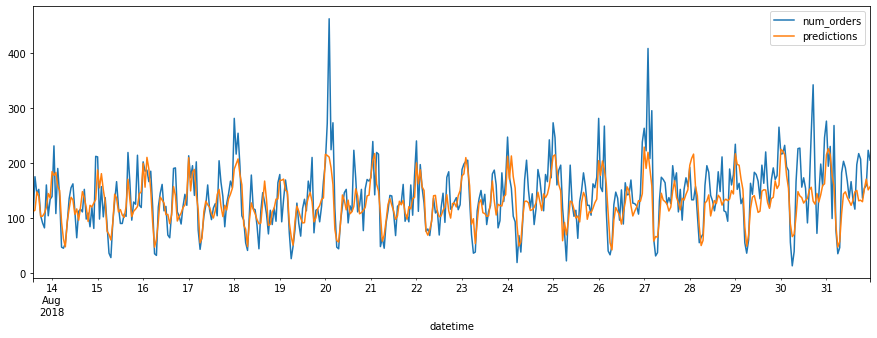

In [24]:
predictions_taxi = pd.DataFrame(data=predicts_test, columns=['predictions'], index=X_test.index)
pd.merge(y_test, predictions_taxi, how = 'left', left_index = True, right_index = True).plot();

## Вывод

Лучше всего для нашей задачи подошла модель LGBMRegressor: RMSE = 41.21.

Хуже результат  показала линейная регрессия, но даже ее результат лучше требуемого: 44.78 < 48.

Как видно из графика выше, наша модель хорошо предсказывает и улавливает сезонность заказов в течении дня, однако плохо улавливает увеличание заказов в выходные дни.